### 将视频每一帧读入frame（List中），每个元素是一个数组。

In [14]:
import cv2
file_Path = r"D:\python project\Vtalk-Recode\examples\face\4.mp4"
video_stream = cv2.VideoCapture(file_Path)
fps = video_stream.get(cv2.CAP_PROP_FPS)

full_frames = []
while True:
    still_reading, frame = video_stream.read()
    if not still_reading:
        video_stream.release()
        break
    y1, y2, x1, x2 = [0, -1, 0, -1]
    if x2 == -1: x2 = frame.shape[1]
    if y2 == -1: y2 = frame.shape[0]
    frame = frame[y1:y2, x1:x2]
    full_frames.append(frame)

199

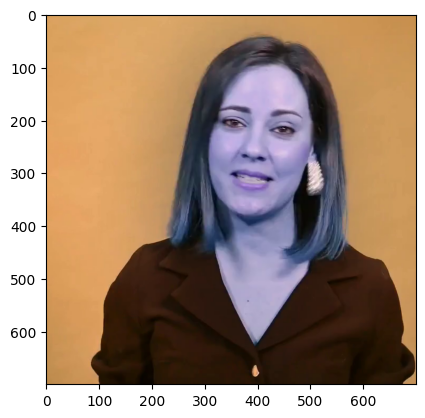

In [15]:
import matplotlib.pyplot as plt
plt.imshow(full_frames[0])
len(full_frames)

### 把头部根据人脸检测模型裁剪下来，保存如full_frames_RGB中（LIST)

In [16]:

from utils.ffhq_preprocess import Croper
croper = Croper('checkpoints/shape_predictor_68_face_landmarks.dat')
full_frames_RGB = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in full_frames]
full_frames_RGB, crop, quad = croper.crop(full_frames_RGB, xsize=512)


### 裁剪下来的头像转换为PIL的格式

In [17]:
from PIL import Image
clx, cly, crx, cry = crop
lx, ly, rx, ry = quad
lx, ly, rx, ry = int(lx), int(ly), int(rx), int(ry)
oy1, oy2, ox1, ox2 = cly+ly, min(cly+ry, full_frames[0].shape[0]), clx+lx, min(clx+rx, full_frames[0].shape[1])
# original_size = (ox2 - ox1, oy2 - oy1)
frames_pil = [Image.fromarray(cv2.resize(frame,(256,256))) for frame in full_frames_RGB]

[37.57687506200216, 19.95187506200213, 446.1231249379979, 428.4981249379979]

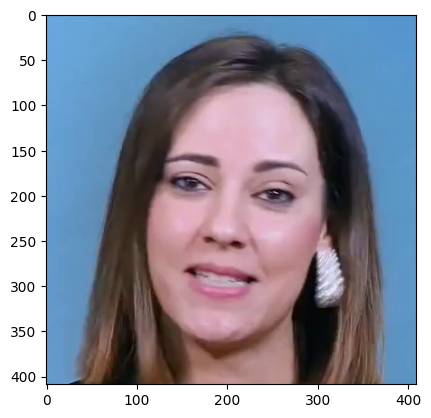

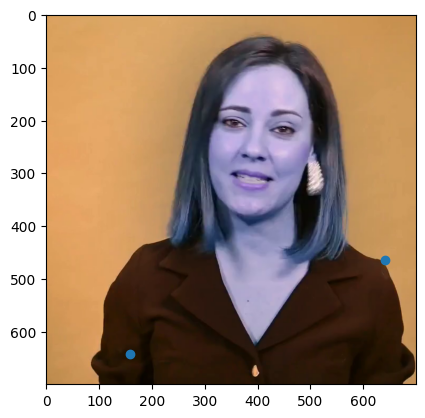

In [18]:

plt.figure()
plt.imshow(full_frames_RGB[0])
plt.figure()
plt.imshow(full_frames[0])
plt.scatter(x= [clx,crx],y= [crx,cry])
quad

In [19]:
from third_part.face3d.extract_kp_videos import KeypointExtractor
kp_extractor = KeypointExtractor()
lm = kp_extractor.extract_keypoint(frames_pil, 'landmarks.txt')
lm.shape ##(帧数，68个检测点，2 坐标) 

landmark Det:: 100%|██████████| 199/199 [01:02<00:00,  3.20it/s]


(199, 68, 2)

### 根据人脸关键点检测点的坐标位置的，得到人脸进行3dmm后的重建系数。

In [21]:
from third_part.face3d.util.load_mats import load_lm3d
from utils.inference_utils import split_coeff,  load_face3d_net
from third_part.face3d.util.preprocess import align_img
import torch
import numpy as np
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

net_recon = load_face3d_net('checkpoints/face3d_pretrain_epoch_20.pth', device)
lm3d_std = load_lm3d('checkpoints/BFM')

video_coeffs = []
for idx in tqdm(range(len(frames_pil)), desc="[Step 2] 3DMM Extraction In Video:"):
    frame = frames_pil[idx]
    W, H = frame.size
    lm_idx = lm[idx].reshape([-1, 2])
    if np.mean(lm_idx) == -1:
        lm_idx = (lm3d_std[:, :2]+1) / 2.
        lm_idx = np.concatenate([lm_idx[:, :1] * W, lm_idx[:, 1:2] * H], 1)
    else:
        lm_idx[:, -1] = H - 1 - lm_idx[:, -1]

    trans_params, im_idx, lm_idx, _ = align_img(frame, lm_idx, lm3d_std)
    trans_params = np.array([float(item) for item in np.hsplit(trans_params, 5)]).astype(np.float32)
    im_idx_tensor = torch.tensor(np.array(im_idx)/255., dtype=torch.float32).permute(2, 0, 1).to(device).unsqueeze(0) 
    with torch.no_grad():
        coeffs = split_coeff(net_recon(im_idx_tensor))

    pred_coeff = {key:coeffs[key].cpu().numpy() for key in coeffs}
    pred_coeff = np.concatenate([pred_coeff['id'], pred_coeff['exp'], pred_coeff['tex'], pred_coeff['angle'],\
                                    pred_coeff['gamma'], pred_coeff['trans'], trans_params[None]], 1)
    video_coeffs.append(pred_coeff)
semantic_npy = np.array(video_coeffs)[:,0]
np.save('3D人脸系数.npy', semantic_npy)
semantic_npy.shape ## (帧数，262)

[Step 2] 3DMM Extraction In Video:: 100%|██████████| 199/199 [00:04<00:00, 41.66it/s]


(199, 262)

### 表情模版


In [23]:
# generate the 3dmm coeff from a single image
expression = "smile"
from scipy.io import loadmat
if expression is not None and ('.png' in expression or '.jpg' in expression):
    print('extract the exp from',expression)
    exp_pil = Image.open(expression).convert('RGB')
    lm3d_std = load_lm3d('third_part/face3d/BFM')
    
    W, H = exp_pil.size
    kp_extractor = KeypointExtractor()
    lm_exp = kp_extractor.extract_keypoint([exp_pil], 'temp/'+base_name+'_temp.txt')[0]
    if np.mean(lm_exp) == -1:
        lm_exp = (lm3d_std[:, :2] + 1) / 2.
        lm_exp = np.concatenate(
            [lm_exp[:, :1] * W, lm_exp[:, 1:2] * H], 1)
    else:
        lm_exp[:, -1] = H - 1 - lm_exp[:, -1]

    trans_params, im_exp, lm_exp, _ = align_img(exp_pil, lm_exp, lm3d_std)
    trans_params = np.array([float(item) for item in np.hsplit(trans_params, 5)]).astype(np.float32)
    im_exp_tensor = torch.tensor(np.array(im_exp)/255., dtype=torch.float32).permute(2, 0, 1).to(device).unsqueeze(0)
    with torch.no_grad():
        expression = split_coeff(net_recon(im_exp_tensor))['exp'][0]
    del net_recon
elif expression == 'smile':
    expression = torch.tensor(loadmat('checkpoints/expression.mat')['expression_mouth'])[0]
else:
    print('using expression center')
    expression = torch.tensor(loadmat('checkpoints/expression.mat')['expression_center'])[0]

### 载入D-net

In [24]:
from models import DNet
# 由于已经训练好 直接从模型权重文件载入
def load_model_weights(model, weight_file):
        # 加载权重
        checkpoint = torch.load(weight_file, map_location=lambda storage, loc: storage)
        # 假设'state_dict'是保存的模型权重
        model.load_state_dict(checkpoint['net_G_ema'],strict=False)
        return model
path =r"D:\python project\Vtalk-Recode\checkpoints\DNet.pt"
D_Net = DNet().to(device)
D_Net = load_model_weights(D_Net,path)

### 采用视频第一帧作为source

In [26]:
from utils.inference_utils import trans_image, transform_semantic, find_crop_norm_ratio
imgs = []
one_shot = True
#D_Net, model = load_model(args, device)
for idx in tqdm(range(len(frames_pil)), desc="[Step 3] Stabilize the expression In Video:"):
    if one_shot:
        source_img = trans_image(frames_pil[0]).unsqueeze(0).to(device)
        semantic_source_numpy = semantic_npy[0:1]
    else:
        source_img = trans_image(frames_pil[idx]).unsqueeze(0).to(device)
        semantic_source_numpy = semantic_npy[idx:idx+1]
    ratio = find_crop_norm_ratio(semantic_source_numpy, semantic_npy)
    coeff = transform_semantic(semantic_npy, idx, ratio).unsqueeze(0).to(device)
    #print(coeff.shape)
    # hacking the new expression
    coeff[:, :64, :] = expression[None, :64, None].to(device)
    #print(coeff.shape) 
    with torch.no_grad():
        output = D_Net(source_img, coeff)
    img_stablized = np.uint8((output['fake_image'].squeeze(0).permute(1,2,0).cpu().clamp_(-1, 1).numpy() + 1 )/2. * 255)
    imgs.append(cv2.cvtColor(img_stablized,cv2.COLOR_RGB2BGR)) 

[Step 3] Stabilize the expression In Video:: 100%|██████████| 199/199 [00:25<00:00,  7.92it/s]


#### D-net的输出写入视频.avi

In [34]:

cv2.imshow('Image',imgs[150])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [30]:
import time
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output.avi', fourcc, 25.0, (256, 256))

for i, image in enumerate(imgs):
    # 在窗口中显示图像，窗口标题为图像的路径
    video.write(image)
video.release()

In [35]:
from utils.inference_utils import trans_image, transform_semantic, find_crop_norm_ratio
imgs = []
one_shot = False

for idx in tqdm(range(len(frames_pil)), desc="[Step 3] Stabilize the expression In Video:"):
    if one_shot:
        source_img = trans_image(frames_pil[0]).unsqueeze(0).to(device)
        semantic_source_numpy = semantic_npy[0:1]
    else:
        source_img = trans_image(frames_pil[idx]).unsqueeze(0).to(device)
        semantic_source_numpy = semantic_npy[idx:idx+1]
    ratio = find_crop_norm_ratio(semantic_source_numpy, semantic_npy)
    coeff = transform_semantic(semantic_npy, idx, ratio).unsqueeze(0).to(device)
    #print(coeff.shape)
    # hacking the new expression
    coeff[:, :64, :] = expression[None, :64, None].to(device)
    
    with torch.no_grad():
        output = D_Net(source_img, coeff)
    img_stablized = np.uint8((output['fake_image'].squeeze(0).permute(1,2,0).cpu().clamp_(-1, 1).numpy() + 1 )/2. * 255)
    imgs.append(cv2.cvtColor(img_stablized,cv2.COLOR_RGB2BGR)) 

[Step 3] Stabilize the expression In Video:: 100%|██████████| 199/199 [00:25<00:00,  7.79it/s]


In [40]:
cv2.imshow('Image',imgs[150])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [36]:
import time
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output one shot=False.avi', fourcc, 25.0, (256, 256))

for i, image in enumerate(imgs):
    # 在窗口中显示图像，窗口标题为图像的路径
    video.write(image)
video.release()

### 加载数据集

#### 定义loss，分别为内容损失和风格损失

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        # 使用VGG16的训练好的模型来提取特征
        vgg = vgg16(pretrained=True)
        # 移除最后的全连接层，保留卷积层和池化层
        self.features = nn.Sequential(*list(vgg.children())[:-1])
        
    def forward(self, input_a, input_b):
        # 分别提取两个输入的特征
        features_a = self.features(input_a)
        features_b = self.features(input_b)
        
        # 计算均方误差损失
        loss = nn.MSELoss()
        loss = loss(features_a, features_b)
        
        return loss

loss = PerceptualLoss()
loss.requires_grad_(False)
a = torch.ones(1,3,256,256)
b = torch.zeros(1,3,256,256)
loss(a, b)

tensor(0.0011)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16
class StyleLoss(nn.Module):
    def __init__(self):
        super(StyleLoss, self).__init__()
        # 使用VGG16的训练好的模型来提取特征
        vgg = vgg16(pretrained=True)
        # 移除最后的全连接层，保留卷积层和池化层
        self.features = nn.Sequential(*list(vgg.children())[:-1])
        
    def forward(self, input_a, input_b):
        # 分别提取两个输入的特征
        features_a = self.features(input_a)
        features_b = self.features(input_b)
        
        # 计算Gram矩阵
        gram_a = self.gram_matrix(features_a)
        gram_b = self.gram_matrix(features_b)
        
        # 计算风格损失
        loss = torch.tensor(0.).to(input_a.device)
        for i in range(gram_a.size(1)):
            loss += F.mse_loss(gram_a[:, i], gram_b[:, i])
        
        return loss / (gram_a.size(1) - 1)
    def gram_matrix(self, input_tensor):
        # 计算输入矩阵的Gram矩阵
        num = input_tensor.size(0)
        gram = torch.matmul(input_tensor, input_tensor.transpose(1, 0))
        gram = gram / num
        return gram

loss = StyleLoss()
loss.requires_grad_(False)
a = torch.ones(1,3,256,256)
b = torch.ones(1,3,256,256)
loss_value = loss(a, b)
loss_value

tensor(0.)

###  trainer 基于pytorchlightning

In [ ]:
from typing import Any, Dict, List, Tuple
import torch.nn as nn 
import pytorch_lightning as pl


_EVALUATE_OUTPUT = List[Dict[str, float]]

class DnetTrainer(pl.LightningModule):
   
    def __init__(self, model: nn.Module ):

        super().__init__()
        self.model = model
        self.closs = PerceptualLoss()
        self.styleloss = StyleLoss()

    def fit(self,
            train_loader: DataLoader,
            val_loader: DataLoader,
            max_epochs: int = 300,
            *args,
            **kwargs) -> Any:
        r'''
        Args:
            train_loader (DataLoader): Iterable DataLoader for traversing the training data batch (:obj:`torch.utils.data.dataloader.DataLoader`, :obj:`torch_geometric.loader.DataLoader`, etc).
            val_loader (DataLoader): Iterable DataLoader for traversing the validation data batch (:obj:`torch.utils.data.dataloader.DataLoader`, :obj:`torch_geometric.loader.DataLoader`, etc).
            max_epochs (int): Maximum number of epochs to train the model. (default: :obj:`300`)
        '''
        trainer = pl.Trainer(devices=self.devices,
                             accelerator=self.accelerator,
                             max_epochs=max_epochs,
                             *args,
                             **kwargs)
        return trainer.fit(self, train_loader, val_loader)

    def test(self, test_loader: DataLoader, *args,
             **kwargs):
        r'''
        Args:
            test_loader (DataLoader): Iterable DataLoader for traversing the test data batch (torch.utils.data.dataloader.DataLoader, torch_geometric.loader.DataLoader, etc).
        '''
        trainer = pl.Trainer(devices=self.devices,
                             accelerator=self.accelerator,
                             *args,
                             **kwargs)
        return trainer.test(self, test_loader)

    def forward(self, x1: torch.Tensor,x2: torch.Tensor):
        return self.model(x1,x2)

    def training_step(self, batch: Tuple[torch.Tensor],
                      batch_idx: int) -> torch.Tensor:
        x1, x2 = batch
        output = self(x1,x2)['fake_image']
        closs = self.closs(x1,output)
        styloss = self.styleloss(x1,output)
        loss = closs+250*styloss
        self.log("train_loss",
                 loss,
                 prog_bar=True,
                 on_epoch=True,
                 on_step=False,
                 logger=True)
        return loss

   
    def validation_step(self, batch: Tuple[torch.Tensor],
                        batch_idx: int) -> torch.Tensor:
        x1, x2 = batch
        output = self(x1,x2)['fake_image']
        closs = self.closs(x1,output)
        styloss = self.styleloss(x1,output)
        loss = closs+250*styloss
        self.log("val_loss",
                 loss,
                 prog_bar=True,
                 on_epoch=True,
                 on_step=False,
                 logger=True)

    
    def test_step(self, batch: Tuple[torch.Tensor],
                  batch_idx: int) -> torch.Tensor:
        x1, x2 = batch
        output = self(x1,x2)['fake_image']
        closs = self.closs(x1,output)
        styloss = self.styleloss(x1,output)
        loss = closs+250*styloss
        self.log("test_loss",
                 loss,
                 prog_bar=True,
                 on_epoch=True,
                 on_step=False,
                 logger=True)
        

    def configure_optimizers(self):
        parameters = list(self.model.parameters())
        trainable_parameters = list(filter(lambda p: p.requires_grad, parameters))
        optimizer = torch.optim.Adam(trainable_parameters,
                                     lr=1e-4)
        return optimizer

    def predict_step(self,
                     batch: Tuple[torch.Tensor],
                     batch_idx: int,
                     dataloader_idx: int = 0):
        x1, x2 = batch
        output = self(x)
        return output

#### 加载数据集 
（请务必经过最上面处理的步骤：人脸检测并裁剪+人脸关键点检测+获得人脸重建系数semantic_npy以及expression模版）

In [41]:
from torch.utils.data import Dataset,DataLoader
class Singlevideo_Dataset(Dataset):
    def __init__(self,frames_pil,semantic_npy,expression = expression) -> None:
        super().__init__()
        self.semantic_npy = semantic_npy
        self.frames_pil = frames_pil
        semantic_source_numpy = semantic_npy[0:1]
        self.ratio = find_crop_norm_ratio(semantic_source_numpy, semantic_npy)
        self.expression = expression
    def __len__(self):
        return len(self.frames_pil)
    def __getitem__(self, idx):
        coeff = transform_semantic(self.semantic_npy, idx, self.ratio).unsqueeze(0).to(device) 
        coeff[:, :64, :] = self.expression[None, :64, None].to(device)
        source_img = trans_image(frames_pil[idx]).to(device)
        return source_img,coeff.squeeze(0)
dataset = Singlevideo_Dataset(frames_pil=frames_pil,semantic_npy=semantic_npy)

In [47]:
print("样本集大小",len(dataset))
train_dataloader = DataLoader(dataset=dataset,batch_size=10)
x1,x2 = next(iter(train_dataloader))
output  = D_Net(x1, x2)
trainer = DnetTrainer(model=D_Net)
trainer.fit(train_dataloader,train_dataloader)
trainer.test(train_dataloader)

样本集大小 199


RuntimeError: CUDA out of memory. Tried to allocate 160.00 MiB (GPU 0; 6.00 GiB total capacity; 11.98 GiB already allocated; 0 bytes free; 12.06 GiB reserved in total by PyTorch)